In [343]:
import random
import numpy as np
from math import sqrt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [344]:
def partite_image(image, block_size):
    height, width = image.shape[0], image.shape[1]
    partitions = []
    
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image[i:i+block_size, j:j+block_size]
            partitions.append(block)
    
    return partitions

In [345]:
def merge_image(blocks, block_size, image):
    merged_image = np.zeros_like(image, dtype=np.float64)
    idx = 0
    for i in range(0, image.shape[0], block_size):
        for j in range(0, image.shape[1], block_size):
            merged_image[i:i+block_size, j:j+block_size] = np.real(blocks[idx])
            idx += 1

    return merged_image

In [346]:
def show_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [347]:
def rgb2gray(image):
    return np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

In [348]:
def perform_svd(A):
    ATA = np.dot(A.T, A)

    eigenvalues, eigenvectors = np.linalg.eigh(ATA)

    eigenvalues = eigenvalues[::-1]
    eigenvectors = eigenvectors[:, ::-1]

    V = np.array(eigenvectors).T

    singular_values = np.sqrt([val if val >= 0 else 0 for val in eigenvalues])
    D = np.diag(singular_values)

    epsilon = 1e-10
    D_inv = np.diag(1 / (singular_values + epsilon))
    U = np.dot(A, np.dot(eigenvectors, D_inv))
    U = U / np.linalg.norm(U, axis=0)

    return U, D, V

In [349]:
def create_watermark_image(block_size):
    watermark = np.zeros((block_size, block_size), dtype=np.float64)
    for i in range(block_size):
        for j in range(block_size):
            watermark[i, j] = random.choice([0, 1])
    return watermark

In [350]:
def watermark_embedded(block, Q, watermark_bit):
    U, D, VT = perform_svd(block)
    Z = D[0][0] % Q
    if not watermark_bit:
        if (Z < 3*Q/4):
            D[0][0] += (Q/4 - Z)
        else:   
            D[0][0] += (5*Q/4 - Z)
    else:
        if (Z < Q/4):
            D[0][0] -= (Q/4 + Z)
        else:   
            D[0][0] += (3*Q/4 - Z)

    return np.dot(U, np.dot(D, VT))

In [351]:
def watermark_extractor(block, Q):
    U, D, VT = perform_svd(block)
    Z = D[0][0] % Q
    if (Z < Q/2):
        return 0
    else:
        return 1

In [352]:
def PSNR_calculation(img1, img2):
    img1_matrix = np.array(img1)
    img2_matrix = np.array(img2)

    mse = np.mean((img1_matrix - img2_matrix) ** 2)

    max_pixel = 255.0
    PSNR = 20 * np.log10(max_pixel) - 10 * np.log10(mse)
    
    return PSNR

In [353]:
def watermarking_process(image, block_size, Q):
    block_nums = image.shape[0] // block_size
    blocks = partite_image(image, block_size)
    watermark_image = create_watermark_image(block_nums)

    watermarked_blocks = []
    for i in range(len(blocks)):
        j = i // block_nums
        k = i % block_nums
        watermarked_blocks.append(watermark_embedded(blocks[i], Q, watermark_image[j][k]))

    watermarked_image = merge_image(watermarked_blocks, block_size, image)

    watermark_extracted = []
    for i in range(len(watermarked_blocks)):
        watermark_extracted.append(watermark_extractor(watermarked_blocks[i], Q))

    watermark_extraction = merge_image(watermark_extracted, block_size, image)

    show_image(image, "Original Image")
    show_image(watermarked_image, "Watermarked Image")
    show_image(watermark_image, "Watermark Image")
    show_image(watermark_extraction, "Extracted Watermark Image")
    psnr_value = PSNR_calculation(image, watermarked_image)
    print("PSNR:", psnr_value)


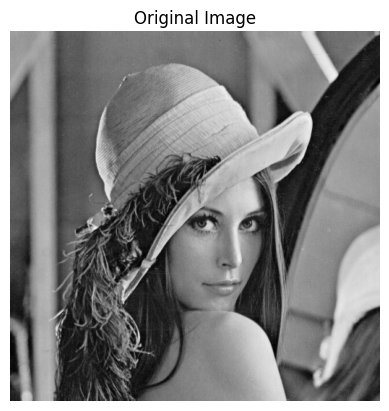

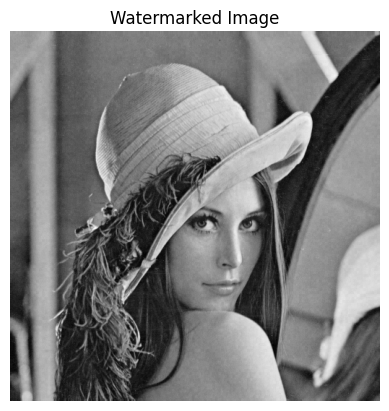

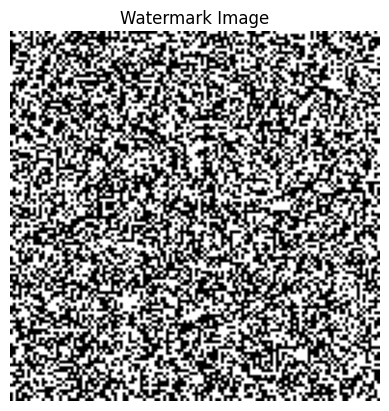

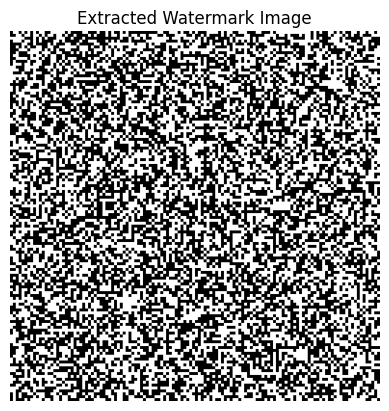

PSNR: 90.99994595619933


In [354]:
image = mpimg.imread("lena.png")
if len(image.shape) == 3:
    image = rgb2gray(image)

block_size = 4
Q = 0.1

watermarking_process(image, block_size, Q)